In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# switch the renderer to use black and white mode and increase the font size for legends
IPythonConsole.drawOptions.useBWAtomPalette()
IPythonConsole.drawOptions.legendFontSize=24


import rdkit
print(rdkit.__version__)

2025.03.1


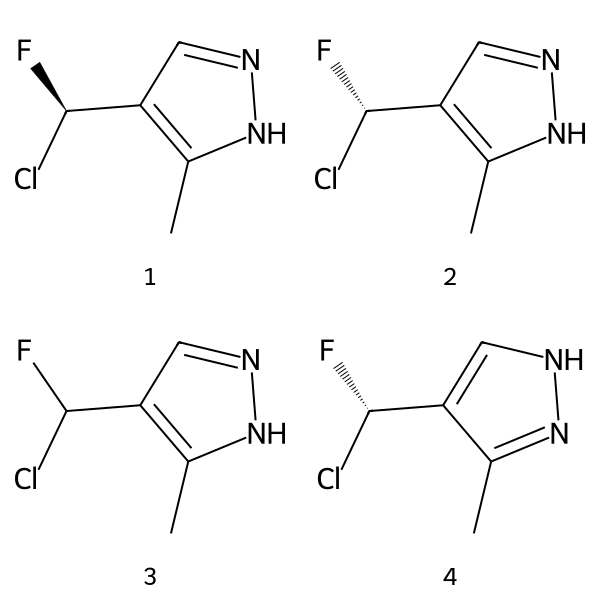

In [ ]:
#キラリティの判定などするためのサンプルデータ4化合物
smis = ["Cc1[nH]ncc1[C@H](F)Cl","Cc1[nH]ncc1[C@@H](F)Cl","Cc1[nH]ncc1[CH](F)Cl","Cc1n[nH]cc1[C@@H](F)Cl"]
ms = [Chem.MolFromSmiles(smi) for smi in smis]
Draw.MolsToGridImage(ms,legends=[str(i+1) for i in range(len(ms))],molsPerRow=2,subImgSize=(300,300))

In [ ]:
#別途用意したpostgreSQL環境に接続する設定を定義
import lwreg

# get the base lwreg configuration:
config = {
    'dbname': 'lwreg_db',            # データベース名
    'user': 'postgres',              # ロール名（ユーザー名）
    'password': 'your_password',        # パスワード（実際の値に置き換えてください）
    'host': 'localhost',             # ホスト名（通常はlocalhost）
    'port': 5432,                    # ポート番号（デフォルトは5432）
    'dbtype': 'postgresql',          # データベース種別
    'cacheConnection': False         # キャッシュ接続（通常はFalse）
}


In [ ]:
#設定を適用
lwreg.set_default_config(config)
config

{'dbname': 'lwreg_db',
 'user': 'postgres',
 'password': your_password',
 'host': 'localhost',
 'port': 5432,
 'dbtype': 'postgresql',
 'cacheConnection': False}

Initialize the database. 
    
**Note** that this erases everything in the current database, so be very careful with this command!

In [13]:
#lwreg.initdb() データベースの初期化は下記コマンド実行後、出てくるウィンドウでyesを入力すると速やかに実行されるはず。1分以上かかるのはおそらくエラー。
lwreg.utils.initdb(config)

This will destroy any existing information in the registration database.


True

In [ ]:
#psycorg2をつかってpostgreSQLデータベースへSQL発行　今回はデータベースの名前とユーザの名前を確認
import psycopg2

conn = psycopg2.connect(
    dbname='lwreg_db',
    user='postgres',
    password='your_password',
    host='localhost',
    port=5432
)
cur = conn.cursor()
cur.execute("SELECT current_database(), current_user;")
print(cur.fetchone())

('lwreg_db', 'postgres')


## Register the compounds

In [15]:
# The RDKit standardizer is quite verbose by default, make it be quiet:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

The best way to register a set of compounds is the `bulk_register()` function. This returns a tuple of the molregnos (registration IDs) of the registered molecules:

In [ ]:
#多数の化合物登録が得意なbulk_register機能を使って4化合物を登録
lwreg.bulk_register(mols=ms)

(1, 2, 3, 4)

## Do some queries:

Here's our query molecule:

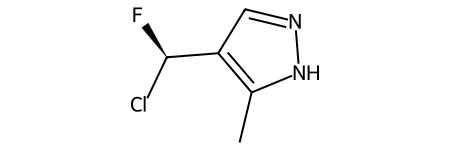

In [ ]:
#検索Query化合物を下記のSMILESとする
Chem.MolFromSmiles('Cc1[nH]ncc1[C@H](F)Cl')

The default behavior of the `query()` function is to return exact matches:

In [ ]:
#デフォルト設定でSMILESでの検索
lwreg.query(smiles='Cc1[nH]ncc1[C@@H](F)Cl')

[2]

We have a lot more flexibility than this though: we can specify which registration hash layers to use in the query.

Query using just the `no_stereo_smiles` layer. This pays attention to tautomers but ignores stereochemistry:

In [ ]:
#立体は考慮しない構造検索
lwreg.query(smiles='Cc1[nH]ncc1[C@H](F)Cl',
            layers=lwreg.utils.HashLayer.NO_STEREO_SMILES)

[1, 2, 3]

The `retrieve()` function allows us to fetch the structures of the molecules corresponding to those molregnos:

In [ ]:
#idを使った一致検索
res = lwreg.retrieve(ids=[1,2,3])
len(res)

3

Any IDs in the list to be retrieved that don't exist are ignored and do not show up in the results:

In [ ]:
#idが一致したレコードしかヒットしない
ids = [1,2,3,56,23,-1]
res = lwreg.retrieve(ids=ids)
len(res)

3

`retrieve()` returns a dictionary with molregnos as keys and two tuples with (molecular structure, format) as the values.

In [ ]:
#検索結果のデータ型を確認
type(res)

dict

In [ ]:
#辞書型データの内容表示
list(res.keys())

[1, 2, 3]

The default behavior is to return the mol block (actually V3000 mol block) that lwreg stores for registered structures:

In [ ]:
#上記辞書resの2番目のレコード(（0 始まりなのでインデックス 1）)を表示。RDKit Mol形式で構造のデータが登録されている
res[1]

('\n     RDKit          2D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 9 9 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 2.775976 0.000000 0.000000 0\nM  V30 2 C 1.275976 0.000000 0.000000 0\nM  V30 3 N 0.394298 1.213525 0.000000 0\nM  V30 4 N -1.032286 0.750000 0.000000 0\nM  V30 5 C -1.032286 -0.750000 0.000000 0\nM  V30 6 C 0.394298 -1.213525 0.000000 0\nM  V30 7 C 0.857824 -2.640110 0.000000 0\nM  V30 8 F -0.145872 -3.754828 0.000000 0\nM  V30 9 Cl 2.325045 -2.951978 0.000000 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 1 1 2\nM  V30 2 1 2 3\nM  V30 3 1 3 4\nM  V30 4 2 4 5\nM  V30 5 1 5 6\nM  V30 6 1 6 7\nM  V30 7 1 7 8 CFG=1\nM  V30 8 1 7 9\nM  V30 9 2 6 2\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n',
 'mol')

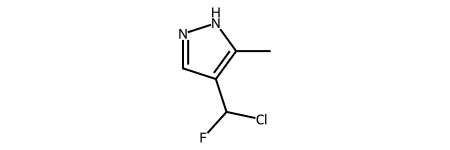

In [ ]:
#リスト res の 4 番目の要素（0 始まりなのでインデックス 3）に含まれる 1 番目の要素（インデックス 0）を参照
Chem.MolFromMolBlock(res[3][0])

## Handling duplicates on registration

Register a bunch more molecules, these are molecules from ChEMBL:

In [ ]:
#WSL2環境内からWindows OS側のDドライブのファイルを読んで3行だけ表示
!head -3 /mnt/d/WSL_Work/lwreg_tutorial/tutorial_data/S1P1_data.csv

"doc_id","molregno","standard_relation","standard_value","standard_units","standard_flag","standard_type","pchembl_value","canonical_smiles","compound_chembl_id"
5839,189018,"=",82,"nM",1,"EC50",7.09,"CCCCCCCCc1ccc(NC(=O)[C@@H](N)COP(=O)(O)O)cc1.OC(=O)C(F)(F)F","CHEMBL332050"
5839,188442,"=",322.1,"nM",1,"EC50",6.49,"CCCCCCCCCCCCCCONC(=O)[C@@H](N)COP(=O)(O)O.OC(=O)C(F)(F)F","CHEMBL115505"


Read all of molecules from that file:

In [ ]:
#CSVファイルのSMILESの列(id = 8)を取得し、0行目はSMILESではなく列名のテキストなので0行目（列名）をpopで削除し、データをクリーンアップする
#SMILESをMol形式に変換してmolsリストに格納
import csv
with open('/mnt/d/WSL_Work/lwreg_tutorial/tutorial_data/S1P1_data.csv','r') as inf:
    rdr = csv.reader(inf)
    smis = [x[8] for x in rdr]
    smis.pop(0)
mols = [Chem.MolFromSmiles(x) for x in smis]

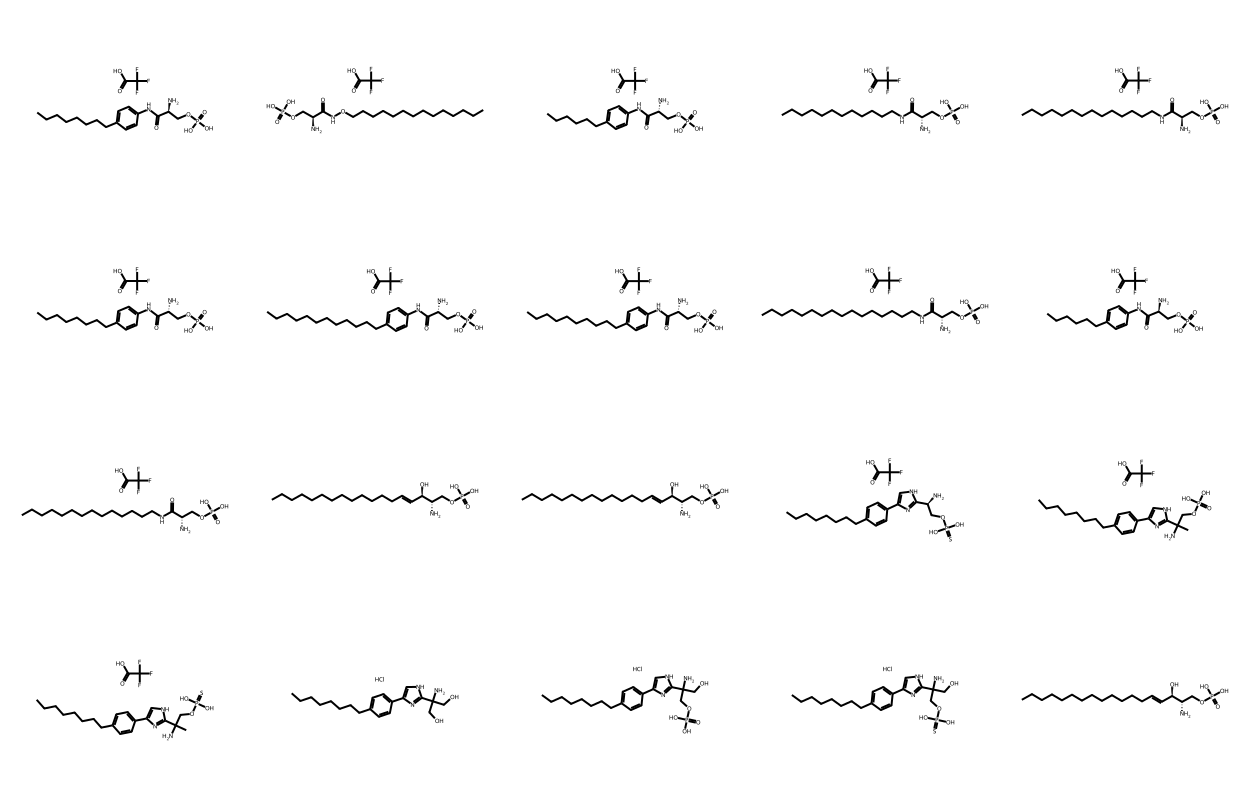

In [ ]:
# mols のリストの最初の 20 個の分子を、5 列ずつのグリッド画像に並べて描画する
# subImgSize によって各分子画像のサイズを 250x200 に設定
Draw.MolsToGridImage(mols[:20],molsPerRow=5,subImgSize=(250,200))

In [ ]:
#リストmolsのデータ数を表示
len(mols)

2253

How many unique molecules are there?

In [ ]:
#セットに変換したら重複した分が除かれたデータ数となる
len(set(Chem.MolToSmiles(m) for m in mols))

2047

So there are >200 duplicates.

Call `bulk_register()` to register those molecules. This takes a couple of minutes:

In [ ]:
# mols のリスト内の分子を一括登録し、登録されたIDを new_ids に保存
new_ids = lwreg.bulk_register(mols=mols)

In [ ]:
len(new_ids)

2253

We end up with a special value in the new_id list for the molecules that are duplicates:

In [ ]:
#重複エラーとなった化合物数
new_ids.count(lwreg.RegistrationFailureReasons.DUPLICATE)

208

Finally just retrieve a molecule and look at it:

In [ ]:
#id = 43 の化合物を取得
res = lwreg.retrieve(id=43)
molb = res[43][0]

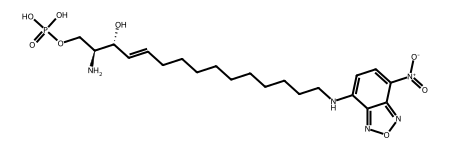

In [ ]:
# molb 文字列から MolBlock フォーマットで分子情報を読み取り、RDKit の分子オブジェクトを作成
Chem.MolFromMolBlock(molb)